# 1. Import Libraries, Weights and Mask Files, and Set Up Directory Paths

In [16]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
# import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import pandas as pd

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = ""

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs/object20220412T1740/")

# 90% Detection Threshold Weights, 20 Epochs
WEIGHTS_PATH = "logs/object20220412T1740/mask_rcnn_object_0085.h5"

# 90% Detection Threshold Weights, 40 Epochs
# WEIGHTS_PATH = "logs/object20220408T2150/mask_rcnn_object_0040.h5"

# 50% Detection Threshold Weights
# WEIGHTS_PATH = "logs/object20220408T1857/mask_rcnn_object_0020.h5"

# 90% Detection Threshold Weights, 20 Epochs, Drivable Area + Lane
# WEIGHTS_PATH = "logs/object20220408T2242/mask_rcnn_object_0020.h5"


In [2]:
# Transfer training and validation data files from Cloud Bucket to local storage in VM instance 
# DON'T NEED TO RUN THIS MORE THAN ONCE!

# from google.cloud import storage
# client = storage.Client()
# DATA_BUCKET = 'w207-final-project'
# databucket = client.get_bucket(DATA_BUCKET)
# datafiles = databucket.list_blobs()
# files=[a.name for a in datafiles if a.name.startswith('val_clean_masks') and a.name.endswith('png')]

# # Copy files from bucket into local folder
# for file in files:
#     blob = databucket.get_blob(file)
#     blob.download_to_filename(file)


# 2. Set Up Model Validation 

## a. Define classes for model configuration and loading images and masks for validation

In [3]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # Background + Drivable Area 

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 2
    # STEPS_PER_EPOCH = 10
    
    # Supported values are: resnet50, resnet101.
    BACKBONE = "resnet101" # Default
    # BACKBONE = "resnet50"

    # Skip detections below % confidence specified
    DETECTION_MIN_CONFIDENCE = 0.9
    #DETECTION_MIN_CONFIDENCE = 0.5


In [4]:

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        """Load a subset of the driving dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """

        # Add classes. We have only one class to add.
        self.add_class("object", 1, "drivable area")
        

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset + "_clean")
        # dataset_dir = os.path.join(dataset_dir, subset + "_test")

        # Given an image (i.e. a row in train_labels_split)
        # Get all the items that are considered drivable area
        # For each item, save the x and y vertices into two lists
        
        if subset == 'train':
            labels = train_labels_cleaned
        else:
            labels = val_labels_cleaned
            
        for index, image in labels.iterrows():

            polygons = []
            objects = []
            for obj in image['labels']:
                x = []
                y = []
                if obj['category'] == 'drivable area':
                    # Label cleaning - constrain maximum vertices to max image resolution
                    for coord in obj['poly2d'][0]['vertices']:
                        if coord[0] >= 1280:
                            x.append(1279)
                        else:
                            x.append(coord[0])
                        if coord[1] >= 720:
                            y.append(719)
                        else:
                            y.append(coord[1])
                    polygons.append({'name': 'polygon',
                                      'all_points_x': x,
                                      'all_points_y': y})
                    objects.append('drivable area')
                    
            image_path = os.path.join(dataset_dir, image['name'])

            # Only use commented code if trying out drivable area and lane. Use the uncommented code for just drivable area evaluation
            name_dict = {"drivable area": 1}
            # name_dict = {"drivable area": 1,"lane": 2}
            
            num_ids = [name_dict[a] for a in objects]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=image['name'],  # use file name as a unique image id
                path=image_path,
                width=1280, height=720,
                polygons=polygons,
                num_ids=num_ids
                )
        return

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


## b. Load object labels


In [5]:

with open('train_clean/bdd100k_labels_images_train.json') as json_file:
    train_labels = json.load(json_file)

with open('val_clean/bdd100k_labels_images_val.json') as json_file:
    val_labels = json.load(json_file)


In [6]:

# REQUIRED: Normalize semi-structured JSON data into a pd dataframe
# Note that train_labels json file contains both labels for training and validation set 
train_labels_normalized = pd.json_normalize(train_labels)

train_filenames = []
val_filenames = []

# REMEMBER TO REPLACE AFTER INITIAL TESTING
for myfile in os.listdir(ROOT_DIR + "train_clean"):
# for myfile in os.listdir(ROOT_DIR + "/train_test"):
    if myfile.endswith(".jpg"):
        train_filenames.append(os.path.join(myfile))

for myfile in os.listdir(ROOT_DIR + "val_clean"):
# for myfile in os.listdir(ROOT_DIR + "/val_test"):
    if myfile.endswith(".jpg"):
        val_filenames.append(os.path.join(myfile))

# Save labels for only the images within the folder contents
train_labels_cleaned = train_labels_normalized.loc[train_labels_normalized['name'].isin(train_filenames)]

# val_labels_split
val_labels_cleaned = train_labels_normalized.loc[train_labels_normalized['name'].isin(val_filenames)]



In [7]:
# Check that files are loaded
print(train_labels_cleaned.shape)
print(val_labels_cleaned.shape)

(3218, 6)
(357, 6)


# 3. Execute Model Validation

In [8]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


# Load validation dataset
CUSTOM_DIR = ""
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 357
Classes: ['BG', 'drivable area']


In [12]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    print("error")

1 Physical GPUs, 1 Logical GPU


In [17]:
#LOAD MODEL. Create model in inference mode

config = CustomConfig()
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [18]:
# Load weights for last model trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  logs/object20220412T1740/mask_rcnn_object_0085.h5
Re-starting from epoch 85


Images: 357
Classes: ['BG', 'drivable area']
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8


2022-04-12 20:40:04.699186: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -50 } dim { size: -310 } dim { size: -311 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 7 } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 1449525

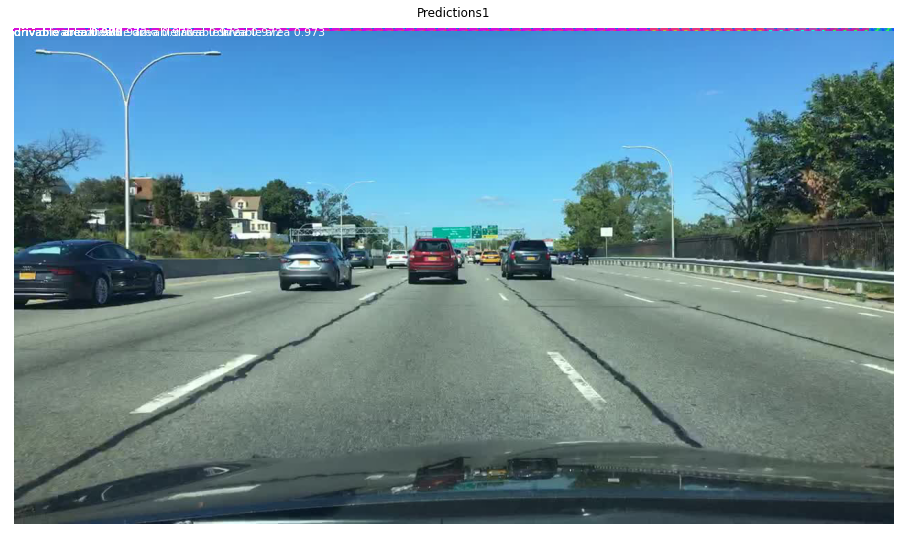

In [19]:
# Display mask results overlaid across a sample image that is run through the model 

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
path_to_new_image = 'train_clean/09486e3a-538126e6.jpg'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
#print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")


# 4. Generate Evaluation Parameters

In [ ]:
# Calculate accuracy, precision, recall, and f1score for all images in dataset

from PIL import Image as im
from sklearn import metrics

i = 1
# Initalize list to store the evaluation parameters
accuracies = []
all_precision = []
all_recall = []
all_f1score = []

for filename in val_filenames:
    image_folder = 'val_clean/'
    
    # Generate classification mask for image by running validation images through model
    image = mpimg.imread(image_folder + filename)
    results = model.detect([image], verbose=1)
    
    # Output of the model is 1280x720x3, so 3 color channels are returned for each pixel. 
    # Values of 0 indicate background and value of 1 indicates drivable area. 
    # Get sum of predicted mask data across the 3rd axis (sum values for each pixel),
    # convert to bool, then convert back to int so that only values of 0 and 1 remain for binary classification.
    pred_mask_data = np.sum(results[0]['masks'], axis = 2).astype(dtype=bool).astype('int')
    pred_masks = pred_mask_data.astype('uint8')*255 # Convert to uint8 and multiply by 255 for image display
    pred_mask_image = im.fromarray(pred_masks)
    
    # Get ground truth masks for each image
    true_mask_folder = 'val_clean_masks/'
    with im.open(true_mask_folder + filename[:-3] + 'png' ) as mask:
        # convert image to numpy array
        true_mask_data = np.asarray(mask)
    # Subtract true mask data by 2 because the ground truth data has background values as 2 in mask, and 0 and 1 values for the drivable areas
    true_mask_data = true_mask_data - 2 
    # Convert to bool then convert back to int so only values of 0 and 1 remain for binary classification
    true_mask_data = true_mask_data.astype(dtype=bool).astype('int') 
    true_masks = true_mask_data.astype('uint8')*255 # Convert to uint8 and multiply by 255 for image display
    
    # Calculation of Accuracy, and append to list of accuracies for all images in validation folder
    acc = metrics.accuracy_score(true_mask_data, pred_mask_data)
    accuracies.append(acc)
      
    # Calculate precision, recall, and F1score for the image, and append to lists for all images
    (precision, recall, f1score, support) = metrics.precision_recall_fscore_support(true_mask_data, pred_mask_data)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1score.append(f1score)
    
    # Print evaluation parameters for the image
    print("Accuracy for %dth image: %f" %(i, acc))
    print("Precision for %dth image: %f" %(i, precision[1]))
    print("Recall for %dth image: %f" %(i, recall[1]))
    print("F1 Score for %dth image: %f" %(i, f1score[1]))
    i += 1


    

In [56]:
# Get Mean Accuracy and combined Precision, Recall, and F1 Score for all images
# Precision, Recall, and F1 Scores are based on True Positives, False Positives,
# and False Negatives calculated across all pixels for all images

print("Mean Accuracy:", np.mean(accuracies))
print("Precision:", np.mean(all_precision))
print("Recall:", np.mean(all_recall))
print("F1 Score:", np.mean(all_f1score))
          

Mean Accuracy: 0.5173630563336445
Precision: 0.016614328235421985
Recall: 0.00023311294171373873
F1 Score: 0.00044574742931671637


image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
Accuracy for 1th image: 0.513889

Mean Accuracy: 0.5138888888888888


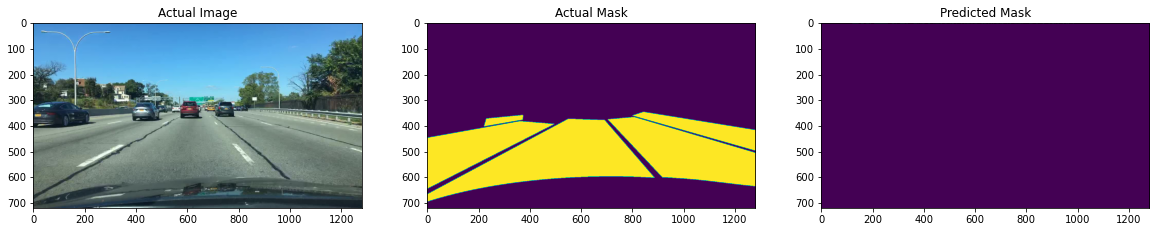

In [21]:
# Display a sample images showing side-by-side the actual image, predicted mask, and true mask for drivable area

from PIL import Image as im
from sklearn import metrics

accuracies = []
i = 1

# Set as the image filename to run through the model for mask prediction
filenames = ['09486e3a-538126e6.jpg']
for filename in filenames:
    image_folder = 'train_clean/'
    
    # Generate classification mask for image
    image = mpimg.imread(image_folder + filename)
    results = model.detect([image], verbose=1)
    pred_mask_data = np.sum(results[0]['masks'], axis = 2).astype(dtype=bool)
    pred_masks = pred_mask_data.astype('uint8')*255
    pred_mask_image = im.fromarray(pred_masks)
    
    
    true_mask_folder = 'train_clean_masks/'

    with im.open(true_mask_folder + filename[:-3] + 'png' ) as mask:
        # convert image to numpy array
        # plt.imshow(image)
        true_image_data = np.asarray(mask)
    true_image_data = true_image_data - 2
    true_image_data = true_image_data.astype(dtype=bool)
    true_masks = true_image_data.astype('uint8')*255
    
    # Calculate Accuracy
    
    acc = metrics.accuracy_score(true_image_data, pred_masks)
    print("Accuracy for %dth image: %f" %(i, acc))
    i += 1
    accuracies.append(acc)
    
    #Display predicted vs ground truth masks
    #Actual Image
    fig, ax = plt.subplots(1, 3, figsize=(20,10))
    ax[0].imshow(image)
    ax[0].set_title('Actual Image')
    # # Ground Truth Mask
    ax[1].imshow(true_masks)
    ax[1].set_title('Actual Mask')
    # # Predicted Mask
    ax[2].imshow(pred_masks)
    ax[2].set_title('Predicted Mask')

    
mean_accuracies = np.mean(accuracies)
print()
print("Mean Accuracy:", mean_accuracies)
